### Read in results YAML from metacoder and do some visualization

In [2]:
import yaml

results_yaml_file = "../results/mcp_literature_eval_results_20250904.yaml"
with open(results_yaml_file, 'r') as file:
    metacoder_results = yaml.safe_load(file)


dict

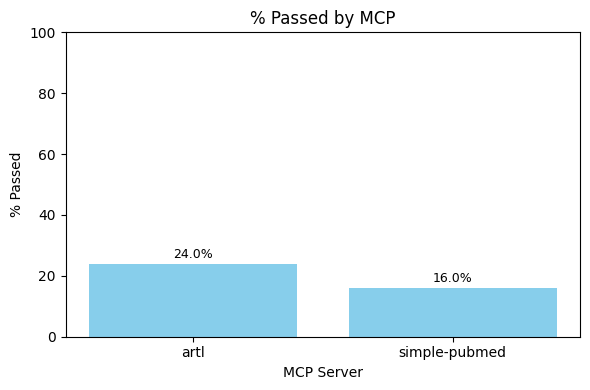

In [9]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# Load YAML
results_yaml_file = "../results/mcp_literature_eval_results_20250904.yaml"
with open(results_yaml_file, 'r') as file:
    metacoder_results = yaml.safe_load(file)

# Convert YAML results to DataFrame
df = pd.DataFrame(metacoder_results['results'])

# Expand rows so each server gets its own row
df = df.explode('servers')

# Use the server as MCP identifier
df['MCP'] = df['servers']

# Calculate % passed for each MCP
percent_passed = (
    df.groupby('MCP')['passed']
    .mean()
    .reset_index()
)
percent_passed['percent_passed'] = percent_passed['passed'] * 100

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percent_passed['MCP'], percent_passed['percent_passed'], color='skyblue')
plt.ylabel('% Passed')
plt.xlabel('MCP Server')
plt.title('% Passed by MCP')
plt.ylim(0, 100)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
